In [3]:
# Célula 1: Configuração inicial completa
import boto3
from botocore.exceptions import ClientError
import json
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from datetime import datetime
import re
from pathlib import Path
import mimetypes

# Configurar clientes AWS
try:
    s3_client = boto3.client('s3', region_name='us-east-1')
    rekognition_client = boto3.client('rekognition', region_name='us-east-1')
    textract_client = boto3.client('textract', region_name='us-east-1')
    
    print("✅ Clientes AWS configurados com sucesso!")
    
    # Verificar bucket
    bucket_name = 'staging-face-text'
    s3_client.head_bucket(Bucket=bucket_name)
    print(f"✅ Bucket '{bucket_name}' acessível!")
    
except Exception as e:
    print(f"❌ Erro na configuração: {e}")

print("🚀 Sistema inicializado! Pronto para processar sua imagem.")

✅ Clientes AWS configurados com sucesso!
✅ Bucket 'staging-face-text' acessível!
🚀 Sistema inicializado! Pronto para processar sua imagem.


In [4]:
# Célula 2: Carregar dados já processados
bucket_name = 'staging-face-text'
image_key = 'processed_Pasted image 20250608090919.png'

# Função para recarregar dados do OCR
def reload_ocr_data():
    """Recarrega dados do OCR já processados"""
    try:
        # Listar arquivos de resultados OCR
        response = s3_client.list_objects_v2(
            Bucket=bucket_name,
            Prefix='ocr_results_'
        )
        
        if 'Contents' in response:
            # Pegar o arquivo mais recente
            latest_file = max(response['Contents'], key=lambda x: x['LastModified'])
            ocr_key = latest_file['Key']
            
            # Baixar e carregar dados
            obj = s3_client.get_object(Bucket=bucket_name, Key=ocr_key)
            ocr_data = json.loads(obj['Body'].read().decode('utf-8'))
            
            print(f"✅ Dados OCR recarregados: {ocr_key}")
            print(f"📊 {ocr_data['total_lines']} linhas, {ocr_data['total_words']} palavras")
            
            return ocr_data
        else:
            print("❌ Nenhum arquivo OCR encontrado")
            return None
            
    except Exception as e:
        print(f"❌ Erro ao recarregar OCR: {e}")
        return None

# Função para recarregar detecção facial
def reload_face_data():
    """Recarrega dados de detecção facial"""
    try:
        response = rekognition_client.detect_faces(
            Image={
                'S3Object': {
                    'Bucket': bucket_name,
                    'Name': image_key
                }
            },
            Attributes=['ALL']
        )
        
        faces = response['FaceDetails']
        print(f"✅ {len(faces)} faces recarregadas")
        
        return faces
        
    except Exception as e:
        print(f"❌ Erro ao recarregar faces: {e}")
        return []

# Recarregar dados
print("🔄 Recarregando dados processados...")
ocr_results = reload_ocr_data()
detected_faces = reload_face_data()

if ocr_results and detected_faces:
    print("✅ Dados recarregados com sucesso!")
    print(f"📄 OCR: {ocr_results['total_words']} palavras extraídas")
    print(f"👥 Faces: {len(detected_faces)} faces detectadas")
else:
    print("❌ Falha ao recarregar dados")

🔄 Recarregando dados processados...
✅ Dados OCR recarregados: ocr_results_20250610_160913.json
📊 36 linhas, 143 palavras
✅ 3 faces recarregadas
✅ Dados recarregados com sucesso!
📄 OCR: 143 palavras extraídas
👥 Faces: 3 faces detectadas


In [5]:
# Célula 3: Funções principais do trabalho
def extract_names_from_ocr(ocr_results):
    """Extrai nomes da CNH e comprovante do texto OCR"""
    
    print("🔍 EXTRAINDO NOMES DOS DOCUMENTOS")
    print("="*40)
    
    full_text = ocr_results['full_text']
    lines = ocr_results['lines']
    
    extracted_data = {
        'cnh_name': None,
        'account_name': None,
        'cnh_cpf': None,
        'found_names': []
    }
    
    print("📄 Texto completo extraído:")
    print("-" * 30)
    print(full_text)
    print("-" * 30)
    
    # Procurar nome na CNH
    for line in lines:
        text = line['text'].strip()
        
        # Padrão para nome na CNH
        if 'NOME' in text.upper() and any(word in text.upper() for word in ['SOCIAL', 'TEST', 'CENTOR']):
            # Extrair nome após "NOME SOCIAL"
            name_match = re.search(r'NOME SOCIAL\s+(.+)', text, re.IGNORECASE)
            if name_match:
                extracted_data['cnh_name'] = name_match.group(1).strip()
                print(f"📄 Nome CNH: {extracted_data['cnh_name']}")
        
        # Procurar CPF
        cpf_match = re.search(r'\b\d{11}\b', text)
        if cpf_match:
            extracted_data['cnh_cpf'] = cpf_match.group()
            print(f"🆔 CPF: {extracted_data['cnh_cpf']}")
        
        # Procurar outros nomes (possível nome do comprovante)
        if (len(text.split()) >= 2 and 
            not any(char.isdigit() for char in text) and
            len(text) > 8 and
            not any(keyword in text.upper() for keyword in 
                   ['FIAP', 'MBA', 'FACE', 'TEXT', 'BRASIL', 'SECRETARIA', 'NACIONAL', 'CARTEIRA'])):
            
            words = text.split()
            if all(len(word) > 2 for word in words):
                extracted_data['found_names'].append({
                    'text': text,
                    'confidence': line['confidence']
                })
    
    # Selecionar melhor candidato para nome do comprovante
    if extracted_data['found_names']:
        # Ordenar por confiança
        best_name = max(extracted_data['found_names'], key=lambda x: x['confidence'])
        extracted_data['account_name'] = best_name['text']
        print(f"🏦 Nome comprovante: {extracted_data['account_name']}")
    
    return extracted_data

def compare_faces_similarity():
    """Compara todas as faces e calcula grau de similaridade"""
    
    print("\n🔍 COMPARAÇÃO FACIAL DETALHADA")
    print("="*50)
    
    if len(detected_faces) < 2:
        print("❌ Menos de 2 faces para comparar")
        return []
    
    # Para comparação, usamos a mesma imagem como source e target
    # mas o Rekognition comparará as faces automaticamente
    comparisons = []
    
    try:
        # Comparar faces usando compare_faces
        response = rekognition_client.compare_faces(
            SourceImage={
                'S3Object': {
                    'Bucket': bucket_name,
                    'Name': image_key
                }
            },
            TargetImage={
                'S3Object': {
                    'Bucket': bucket_name,
                    'Name': image_key
                }
            },
            SimilarityThreshold=50.0  # Threshold baixo para capturar todas
        )
        
        print(f"🎯 Análise de similaridade entre faces:")
        
        if response['FaceMatches']:
            for i, match in enumerate(response['FaceMatches']):
                similarity = match['Similarity']
                confidence = match['Face']['Confidence']
                
                comparison = {
                    'pair': f"Face comparação {i+1}",
                    'similarity': similarity,
                    'confidence': confidence,
                    'meets_90_threshold': similarity >= 90.0,
                    'meets_80_threshold': similarity >= 80.0
                }
                
                comparisons.append(comparison)
                
                print(f"\n👥 Comparação {i+1}:")
                print(f"   🎯 Similaridade: {similarity:.2f}%")
                print(f"   🔍 Confiança: {confidence:.2f}%")
                print(f"   ✅ Atende 90%: {'SIM' if similarity >= 90.0 else 'NÃO'}")
                print(f"   ✅ Atende 80%: {'SIM' if similarity >= 80.0 else 'NÃO'}")
        
        # Análise adicional: comparar faces por posição
        print(f"\n📊 ANÁLISE POR POSIÇÃO DAS FACES:")
        for i, face in enumerate(detected_faces):
            bbox = face['BoundingBox']
            print(f"   Face {i+1}: Posição ({bbox['Left']:.3f}, {bbox['Top']:.3f}) - Confiança: {face['Confidence']:.2f}%")
        
        return comparisons
        
    except Exception as e:
        print(f"❌ Erro na comparação: {e}")
        return []

def compare_names(extracted_data):
    """Compara nomes extraídos da CNH e comprovante"""
    
    print(f"\n📋 COMPARAÇÃO DE NOMES")
    print("="*30)
    
    cnh_name = extracted_data.get('cnh_name')
    account_name = extracted_data.get('account_name')
    
    print(f"📄 Nome CNH: {cnh_name}")
    print(f"🏦 Nome Comprovante: {account_name}")
    
    if cnh_name and account_name:
        # Normalizar nomes para comparação
        cnh_normalized = re.sub(r'[^A-Za-z\s]', '', cnh_name.upper()).strip()
        account_normalized = re.sub(r'[^A-Za-z\s]', '', account_name.upper()).strip()
        
        # Calcular similaridade simples
        cnh_words = set(cnh_normalized.split())
        account_words = set(account_normalized.split())
        
        if cnh_words and account_words:
            intersection = cnh_words.intersection(account_words)
            union = cnh_words.union(account_words)
            similarity = len(intersection) / len(union) * 100
            
            print(f"\n🔍 Análise de similaridade:")
            print(f"   📄 CNH normalizado: {cnh_normalized}")
            print(f"   🏦 Comprovante normalizado: {account_normalized}")
            print(f"   🎯 Similaridade: {similarity:.2f}%")
            print(f"   ✅ Nomes {'COMPATÍVEIS' if similarity > 50 else 'DIFERENTES'}")
            
            return {
                'cnh_name': cnh_name,
                'account_name': account_name,
                'similarity': similarity,
                'compatible': similarity > 50
            }
    
    print("❌ Não foi possível comparar os nomes")
    return None

print("📦 Funções de comparação configuradas!")

📦 Funções de comparação configuradas!


In [6]:
# Célula 4: Executar todas as análises solicitadas no trabalho
print("🚀 EXECUTANDO ANÁLISES COMPLETAS DO TRABALHO")
print("="*60)

# 1. Extrair nomes
print("\n1️⃣ EXTRAÇÃO DE NOMES")
extracted_names = extract_names_from_ocr(ocr_results)

# 2. Comparar faces
print("\n2️⃣ COMPARAÇÃO FACIAL")
face_comparisons = compare_faces_similarity()

# 3. Comparar nomes
print("\n3️⃣ COMPARAÇÃO DE NOMES")
name_comparison = compare_names(extracted_names)

# 4. Relatório final
print("\n" + "="*60)
print("📋 RELATÓRIO FINAL DO TRABALHO")
print("="*60)

print(f"📸 Imagem processada: {image_key}")
print(f"🕐 Data/Hora: {datetime.now().strftime('%d/%m/%Y às %H:%M:%S')}")

print(f"\n👥 DETECÇÃO FACIAL:")
print(f"   • Faces detectadas: {len(detected_faces)}")
for i, face in enumerate(detected_faces, 1):
    print(f"   • Face {i}: {face['Confidence']:.2f}% confiança")

print(f"\n🔍 COMPARAÇÃO FACIAL:")
if face_comparisons:
    for comp in face_comparisons:
        print(f"   • {comp['pair']}: {comp['similarity']:.2f}% similaridade")
        print(f"     ✅ Atende 90%: {'SIM' if comp['meets_90_threshold'] else 'NÃO'}")
else:
    print("   • Análise de similaridade em andamento...")

print(f"\n📄 EXTRAÇÃO DE DADOS:")
print(f"   • Nome CNH: {extracted_names.get('cnh_name', 'Não encontrado')}")
print(f"   • CPF: {extracted_names.get('cnh_cpf', 'Não encontrado')}")
print(f"   • Nome Comprovante: {extracted_names.get('account_name', 'Não encontrado')}")

print(f"\n📋 COMPARAÇÃO DE NOMES:")
if name_comparison:
    print(f"   • Similaridade: {name_comparison['similarity']:.2f}%")
    print(f"   • Status: {'COMPATÍVEIS' if name_comparison['compatible'] else 'DIFERENTES'}")
else:
    print("   • Não foi possível comparar")

print(f"\n✅ CONCLUSÃO:")
faces_ok = len(detected_faces) >= 2
names_ok = name_comparison and name_comparison['compatible'] if name_comparison else False
similarity_ok = any(comp['meets_90_threshold'] for comp in face_comparisons) if face_comparisons else False

print(f"   • Detecção facial: {'✅ OK' if faces_ok else '❌ FALHA'}")
print(f"   • Comparação facial 90%: {'✅ OK' if similarity_ok else '❌ FALHA'}")
print(f"   • Compatibilidade nomes: {'✅ OK' if names_ok else '❌ FALHA'}")

status = "APROVADO" if (faces_ok and (similarity_ok or names_ok)) else "REPROVADO"
print(f"\n🎯 STATUS FINAL: {status}")

print("="*60)

🚀 EXECUTANDO ANÁLISES COMPLETAS DO TRABALHO

1️⃣ EXTRAÇÃO DE NOMES
🔍 EXTRAINDO NOMES DOS DOCUMENTOS
📄 Texto completo extraído:
------------------------------
FIAP MBA+
FACE & TEXT EXTRACTION
o setor de fraudes apontou que existem clientes que se queixaram de não contratar serviços
específicos, como o crédito pessoal. Entretanto após o indicador de Detecção de vivacidade
(liveness), desenvolvido na disciplina de Computer Vision, ter apresentado um percentual de
vivacidade menor que 90% apontou a necessidade de uma nova validação do self da pessoa com o
documento.
REPUBLICA FEDERATIVA 00 BRASIL
BR
SECRETARIA NACIONA TRANSITO
CARTERA NACIONAL DE HABULTACIO DRIVER LICENSE PERMISO DE CONDUCCION
see
det
NOME SOCIAL TEST CENTOR DEZ
16090389 SAO PALLOSS
-
Miss referencia
Date
- business
26060022
85 3691-7258
JULHO 2022
12/07/2022
R$
101.48
503584349
000000
1195
-
10
PA/DO TERTE HCM 5
1. Extração da Face, Nome e CPF
2. Comparação de faces (precisam ter
3. Extração do Nome e Endereço. Nome
mais 

In [7]:
# Célula 3 MODIFICADA: Funções principais do trabalho
# MODIFICAÇÃO: Tratando NOME e NOME SOCIAL como variáveis equivalentes
# Justificativa: Em documentos brasileiros, NOME SOCIAL tem a mesma validade legal que NOME
# para fins de identificação e comparação de identidade

def extract_names_from_ocr(ocr_results):
    """Extrai nomes da CNH e comprovante do texto OCR"""
    
    print("🔍 EXTRAINDO NOMES DOS DOCUMENTOS")
    print("="*40)
    
    full_text = ocr_results['full_text']
    lines = ocr_results['lines']
    
    extracted_data = {
        'cnh_name': None,
        'cnh_social_name': None,  # NOVO: Campo específico para nome social
        'account_name': None,
        'cnh_cpf': None,
        'found_names': []
    }
    
    print("📄 Texto completo extraído:")
    print("-" * 30)
    print(full_text)
    print("-" * 30)
    
    # MODIFICAÇÃO: Procurar tanto NOME quanto NOME SOCIAL
    for line in lines:
        text = line['text'].strip()
        
        # Padrão para NOME SOCIAL na CNH
        if 'NOME SOCIAL' in text.upper():
            name_match = re.search(r'NOME SOCIAL\s+(.+)', text, re.IGNORECASE)
            if name_match:
                extracted_data['cnh_social_name'] = name_match.group(1).strip()
                print(f"📄 Nome Social CNH: {extracted_data['cnh_social_name']}")
        
        # Padrão para NOME comum na CNH (caso não tenha NOME SOCIAL)
        elif 'NOME' in text.upper() and 'SOCIAL' not in text.upper():
            name_match = re.search(r'NOME\s+(.+)', text, re.IGNORECASE)
            if name_match:
                extracted_data['cnh_name'] = name_match.group(1).strip()
                print(f"📄 Nome CNH: {extracted_data['cnh_name']}")
        
        # Procurar CPF
        cpf_match = re.search(r'\b\d{11}\b', text)
        if cpf_match:
            extracted_data['cnh_cpf'] = cpf_match.group()
            print(f"🆔 CPF: {extracted_data['cnh_cpf']}")
        
        # Procurar outros nomes (possível nome do comprovante)
        if (len(text.split()) >= 2 and 
            not any(char.isdigit() for char in text) and
            len(text) > 8 and
            not any(keyword in text.upper() for keyword in 
                   ['FIAP', 'MBA', 'FACE', 'TEXT', 'BRASIL', 'SECRETARIA', 'NACIONAL', 'CARTEIRA'])):
            
            words = text.split()
            if all(len(word) > 2 for word in words):
                extracted_data['found_names'].append({
                    'text': text,
                    'confidence': line['confidence']
                })
    
    # Selecionar melhor candidato para nome do comprovante
    if extracted_data['found_names']:
        best_name = max(extracted_data['found_names'], key=lambda x: x['confidence'])
        extracted_data['account_name'] = best_name['text']
        print(f"🏦 Nome comprovante: {extracted_data['account_name']}")
    
    # NOVO: Definir nome principal da CNH (prioriza NOME SOCIAL se existir)
    extracted_data['cnh_primary_name'] = (
        extracted_data['cnh_social_name'] or extracted_data['cnh_name']
    )
    
    print(f"✅ Nome principal CNH definido: {extracted_data['cnh_primary_name']}")
    
    return extracted_data

def compare_faces_similarity():
    """Compara todas as faces e calcula grau de similaridade"""
    
    print("\n🔍 COMPARAÇÃO FACIAL DETALHADA")
    print("="*50)
    
    if len(detected_faces) < 2:
        print("❌ Menos de 2 faces para comparar")
        return []
    
    comparisons = []
    
    try:
        response = rekognition_client.compare_faces(
            SourceImage={
                'S3Object': {
                    'Bucket': bucket_name,
                    'Name': image_key
                }
            },
            TargetImage={
                'S3Object': {
                    'Bucket': bucket_name,
                    'Name': image_key
                }
            },
            SimilarityThreshold=50.0
        )
        
        print(f"🎯 Análise de similaridade entre faces:")
        
        if response['FaceMatches']:
            for i, match in enumerate(response['FaceMatches']):
                similarity = match['Similarity']
                confidence = match['Face']['Confidence']
                
                comparison = {
                    'pair': f"Face comparação {i+1}",
                    'similarity': similarity,
                    'confidence': confidence,
                    'meets_90_threshold': similarity >= 90.0,
                    'meets_80_threshold': similarity >= 80.0
                }
                
                comparisons.append(comparison)
                
                print(f"\n👥 Comparação {i+1}:")
                print(f"   🎯 Similaridade: {similarity:.2f}%")
                print(f"   🔍 Confiança: {confidence:.2f}%")
                print(f"   ✅ Atende 90%: {'SIM' if similarity >= 90.0 else 'NÃO'}")
                print(f"   ✅ Atende 80%: {'SIM' if similarity >= 80.0 else 'NÃO'}")
        
        print(f"\n📊 ANÁLISE POR POSIÇÃO DAS FACES:")
        for i, face in enumerate(detected_faces):
            bbox = face['BoundingBox']
            print(f"   Face {i+1}: Posição ({bbox['Left']:.3f}, {bbox['Top']:.3f}) - Confiança: {face['Confidence']:.2f}%")
        
        return comparisons
        
    except Exception as e:
        print(f"❌ Erro na comparação: {e}")
        return []

def compare_names_standard(extracted_data):
    """COMPARAÇÃO PADRÃO: Compara nomes extraídos da CNH e comprovante (método original)"""
    
    print(f"\n📋 COMPARAÇÃO DE NOMES - MÉTODO PADRÃO")
    print("="*40)
    
    cnh_name = extracted_data.get('cnh_name')
    account_name = extracted_data.get('account_name')
    
    print(f"📄 Nome CNH (padrão): {cnh_name}")
    print(f"🏦 Nome Comprovante: {account_name}")
    
    if cnh_name and account_name:
        # Normalizar nomes para comparação
        cnh_normalized = re.sub(r'[^A-Za-z\s]', '', cnh_name.upper()).strip()
        account_normalized = re.sub(r'[^A-Za-z\s]', '', account_name.upper()).strip()
        
        # Calcular similaridade simples
        cnh_words = set(cnh_normalized.split())
        account_words = set(account_normalized.split())
        
        if cnh_words and account_words:
            intersection = cnh_words.intersection(account_words)
            union = cnh_words.union(account_words)
            similarity = len(intersection) / len(union) * 100
            
            print(f"\n🔍 Análise de similaridade (método padrão):")
            print(f"   📄 CNH normalizado: {cnh_normalized}")
            print(f"   🏦 Comprovante normalizado: {account_normalized}")
            print(f"   🎯 Similaridade: {similarity:.2f}%")
            print(f"   ✅ Nomes {'COMPATÍVEIS' if similarity > 50 else 'DIFERENTES'}")
            
            return {
                'method': 'standard',
                'cnh_name': cnh_name,
                'account_name': account_name,
                'similarity': similarity,
                'compatible': similarity > 50
            }
    
    print("❌ Não foi possível comparar os nomes (método padrão)")
    return None

def compare_names_enhanced(extracted_data):
    """
    COMPARAÇÃO APRIMORADA: Considera NOME e NOME SOCIAL como equivalentes
    
    JUSTIFICATIVA TÉCNICA:
    - No Brasil, o Nome Social tem validade legal equivalente ao Nome Civil
    - Para sistemas de validação de identidade, ambos devem ser aceitos
    - Esta abordagem aumenta a precisão em casos de pessoas trans ou com nomes sociais
    - Melhora a experiência do usuário sem comprometer a segurança
    """
    
    print(f"\n📋 COMPARAÇÃO DE NOMES - MÉTODO APRIMORADO")
    print("="*40)
    print("💡 CONSIDERANDO NOME e NOME SOCIAL como equivalentes")
    
    # Usar nome principal (prioriza NOME SOCIAL se existir)
    cnh_primary_name = extracted_data.get('cnh_primary_name')
    account_name = extracted_data.get('account_name')
    
    print(f"📄 Nome CNH (principal): {cnh_primary_name}")
    print(f"🏦 Nome Comprovante: {account_name}")
    
    # Mostrar detalhes dos nomes encontrados
    if extracted_data.get('cnh_social_name'):
        print(f"   ℹ️  Nome Social detectado: {extracted_data['cnh_social_name']}")
    if extracted_data.get('cnh_name'):
        print(f"   ℹ️  Nome Civil detectado: {extracted_data['cnh_name']}")
    
    if cnh_primary_name and account_name:
        # Normalizar nomes para comparação
        cnh_normalized = re.sub(r'[^A-Za-z\s]', '', cnh_primary_name.upper()).strip()
        account_normalized = re.sub(r'[^A-Za-z\s]', '', account_name.upper()).strip()
        
        # Calcular similaridade
        cnh_words = set(cnh_normalized.split())
        account_words = set(account_normalized.split())
        
        if cnh_words and account_words:
            intersection = cnh_words.intersection(account_words)
            union = cnh_words.union(account_words)
            similarity = len(intersection) / len(union) * 100
            
            print(f"\n🔍 Análise de similaridade (método aprimorado):")
            print(f"   📄 CNH normalizado: {cnh_normalized}")
            print(f"   🏦 Comprovante normalizado: {account_normalized}")
            print(f"   🎯 Similaridade: {similarity:.2f}%")
            print(f"   ✅ Nomes {'COMPATÍVEIS' if similarity > 50 else 'DIFERENTES'}")
            
            # Análise adicional: verificar se pelo menos um nome principal está presente
            main_words_match = False
            if cnh_words and account_words:
                # Verificar se pelo menos 50% das palavras principais coincidem
                main_words_match = len(intersection) >= max(1, min(len(cnh_words), len(account_words)) * 0.5)
            
            print(f"   🎯 Correspondência de palavras principais: {'SIM' if main_words_match else 'NÃO'}")
            
            return {
                'method': 'enhanced',
                'cnh_primary_name': cnh_primary_name,
                'account_name': account_name,
                'similarity': similarity,
                'compatible': similarity > 50,
                'main_words_match': main_words_match,
                'enhanced_compatible': similarity > 50 or main_words_match
            }
    
    print("❌ Não foi possível comparar os nomes (método aprimorado)")
    return None

print("📦 Funções de comparação configuradas com tratamento NOME/NOME SOCIAL!")

📦 Funções de comparação configuradas com tratamento NOME/NOME SOCIAL!


In [8]:
# Célula 4 MODIFICADA: Executar todas as análises com comparação dupla
print("🚀 EXECUTANDO ANÁLISES COMPLETAS DO TRABALHO")
print("="*60)

# 1. Extrair nomes
print("\n1️⃣ EXTRAÇÃO DE NOMES")
extracted_names = extract_names_from_ocr(ocr_results)

# 2. Comparar faces
print("\n2️⃣ COMPARAÇÃO FACIAL")
face_comparisons = compare_faces_similarity()

# 3. Comparar nomes - MÉTODO PADRÃO
print("\n3️⃣ COMPARAÇÃO DE NOMES - MÉTODO PADRÃO")
name_comparison_standard = compare_names_standard(extracted_names)

# 4. Comparar nomes - MÉTODO APRIMORADO (NOVO)
print("\n4️⃣ COMPARAÇÃO DE NOMES - MÉTODO APRIMORADO")
name_comparison_enhanced = compare_names_enhanced(extracted_names)

# 5. Relatório final comparativo
print("\n" + "="*60)
print("📋 RELATÓRIO FINAL COMPARATIVO")
print("="*60)

print(f"📸 Imagem processada: {image_key}")
print(f"🕐 Data/Hora: {datetime.now().strftime('%d/%m/%Y às %H:%M:%S')}")

print(f"\n👥 DETECÇÃO FACIAL:")
print(f"   • Faces detectadas: {len(detected_faces)}")
for i, face in enumerate(detected_faces, 1):
    print(f"   • Face {i}: {face['Confidence']:.2f}% confiança")

print(f"\n🔍 COMPARAÇÃO FACIAL:")
if face_comparisons:
    for comp in face_comparisons:
        print(f"   • {comp['pair']}: {comp['similarity']:.2f}% similaridade")
        print(f"     ✅ Atende 90%: {'SIM' if comp['meets_90_threshold'] else 'NÃO'}")
else:
    print("   • Análise de similaridade em andamento...")

print(f"\n📄 EXTRAÇÃO DE DADOS:")
print(f"   • Nome Civil CNH: {extracted_names.get('cnh_name', 'Não encontrado')}")
print(f"   • Nome Social CNH: {extracted_names.get('cnh_social_name', 'Não encontrado')}")
print(f"   • Nome Principal CNH: {extracted_names.get('cnh_primary_name', 'Não encontrado')}")
print(f"   • CPF: {extracted_names.get('cnh_cpf', 'Não encontrado')}")
print(f"   • Nome Comprovante: {extracted_names.get('account_name', 'Não encontrado')}")

print(f"\n📋 COMPARAÇÃO DE NOMES - RESULTADOS:")

# Método Padrão
print(f"\n   🔹 MÉTODO PADRÃO (apenas Nome Civil):")
if name_comparison_standard:
    print(f"     • Similaridade: {name_comparison_standard['similarity']:.2f}%")
    print(f"     • Status: {'COMPATÍVEIS' if name_comparison_standard['compatible'] else 'DIFERENTES'}")
else:
    print(f"     • Não foi possível comparar")

# Método Aprimorado
print(f"\n   🔹 MÉTODO APRIMORADO (Nome Civil + Nome Social):")
if name_comparison_enhanced:
    print(f"     • Similaridade: {name_comparison_enhanced['similarity']:.2f}%")
    print(f"     • Status básico: {'COMPATÍVEIS' if name_comparison_enhanced['compatible'] else 'DIFERENTES'}")
    print(f"     • Correspondência principal: {'SIM' if name_comparison_enhanced['main_words_match'] else 'NÃO'}")
    print(f"     • Status aprimorado: {'COMPATÍVEIS' if name_comparison_enhanced['enhanced_compatible'] else 'DIFERENTES'}")
else:
    print(f"     • Não foi possível comparar")

print(f"\n✅ CONCLUSÕES FINAIS:")

# Validações
faces_ok = len(detected_faces) >= 2
similarity_ok = any(comp['meets_90_threshold'] for comp in face_comparisons) if face_comparisons else False

# Comparação de nomes - ambos os métodos
names_standard_ok = name_comparison_standard and name_comparison_standard['compatible'] if name_comparison_standard else False
names_enhanced_ok = name_comparison_enhanced and name_comparison_enhanced['enhanced_compatible'] if name_comparison_enhanced else False

print(f"   • Detecção facial: {'✅ OK' if faces_ok else '❌ FALHA'}")
print(f"   • Comparação facial 90%: {'✅ OK' if similarity_ok else '❌ FALHA'}")
print(f"   • Compatibilidade nomes (padrão): {'✅ OK' if names_standard_ok else '❌ FALHA'}")
print(f"   • Compatibilidade nomes (aprimorado): {'✅ OK' if names_enhanced_ok else '❌ FALHA'}")

# Status final considerando ambos os métodos
status_standard = "APROVADO" if (faces_ok and (similarity_ok or names_standard_ok)) else "REPROVADO"
status_enhanced = "APROVADO" if (faces_ok and (similarity_ok or names_enhanced_ok)) else "REPROVADO"

print(f"\n🎯 STATUS FINAL:")
print(f"   • Método Padrão: {status_standard}")
print(f"   • Método Aprimorado: {status_enhanced}")

# Recomendação
if status_enhanced == "APROVADO" and status_standard == "REPROVADO":
    print(f"\n💡 RECOMENDAÇÃO: O método aprimorado aprovou onde o padrão reprovou")
    print(f"   Isso indica que o Nome Social foi fundamental para a validação")

print("="*60)

🚀 EXECUTANDO ANÁLISES COMPLETAS DO TRABALHO

1️⃣ EXTRAÇÃO DE NOMES
🔍 EXTRAINDO NOMES DOS DOCUMENTOS
📄 Texto completo extraído:
------------------------------
FIAP MBA+
FACE & TEXT EXTRACTION
o setor de fraudes apontou que existem clientes que se queixaram de não contratar serviços
específicos, como o crédito pessoal. Entretanto após o indicador de Detecção de vivacidade
(liveness), desenvolvido na disciplina de Computer Vision, ter apresentado um percentual de
vivacidade menor que 90% apontou a necessidade de uma nova validação do self da pessoa com o
documento.
REPUBLICA FEDERATIVA 00 BRASIL
BR
SECRETARIA NACIONA TRANSITO
CARTERA NACIONAL DE HABULTACIO DRIVER LICENSE PERMISO DE CONDUCCION
see
det
NOME SOCIAL TEST CENTOR DEZ
16090389 SAO PALLOSS
-
Miss referencia
Date
- business
26060022
85 3691-7258
JULHO 2022
12/07/2022
R$
101.48
503584349
000000
1195
-
10
PA/DO TERTE HCM 5
1. Extração da Face, Nome e CPF
2. Comparação de faces (precisam ter
3. Extração do Nome e Endereço. Nome
mais 

In [9]:
# Célula 5: Sistema completo de visualização com anotações
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import io
import requests

def download_image_from_s3(bucket_name, image_key, local_path):
    """Baixa imagem do S3 para processamento local"""
    try:
        s3_client.download_file(bucket_name, image_key, local_path)
        print(f"✅ Imagem baixada: {local_path}")
        return True
    except Exception as e:
        print(f"❌ Erro ao baixar imagem: {e}")
        return False

def draw_face_rectangles_and_labels(image_path, faces_data, extracted_names, output_path):
    """
    Desenha retângulos nas faces detectadas e adiciona labels com informações
    
    Args:
        image_path: Caminho da imagem
        faces_data: Lista de faces detectadas
        extracted_names: Dados extraídos (nomes, CPF, etc.)
        output_path: Caminho para salvar imagem anotada
    """
    try:
        # Carregar imagem
        image = Image.open(image_path)
        draw = ImageDraw.Draw(image)
        
        # Configurar fonte (usar fonte padrão se não conseguir carregar)
        try:
            font_large = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", 20)
            font_medium = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf", 16)
            font_small = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf", 12)
        except:
            font_large = ImageFont.load_default()
            font_medium = ImageFont.load_default()
            font_small = ImageFont.load_default()
        
        # Dimensões da imagem
        img_width, img_height = image.size
        
        # Cores para diferentes faces
        colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF', '#00FFFF']
        
        # Desenhar retângulos e labels para cada face
        for i, face in enumerate(faces_data):
            bbox = face['BoundingBox']
            
            # Converter coordenadas relativas para absolutas
            left = int(bbox['Left'] * img_width)
            top = int(bbox['Top'] * img_height)
            width = int(bbox['Width'] * img_width)
            height = int(bbox['Height'] * img_height)
            
            # Cor para esta face
            color = colors[i % len(colors)]
            
            # Desenhar retângulo
            draw.rectangle(
                [(left, top), (left + width, top + height)],
                outline=color,
                width=3
            )
            
            # Preparar informações da face
            confidence = face['Confidence']
            age_range = face.get('AgeRange', {})
            gender = face.get('Gender', {})
            emotions = face.get('Emotions', [])
            
            # Emoção principal
            top_emotion = max(emotions, key=lambda x: x['Confidence']) if emotions else None
            
            # Label principal
            label = f"Face {i+1}"
            sublabel = f"Conf: {confidence:.1f}%"
            
            # Informações adicionais
            if age_range:
                age_info = f"Idade: {age_range.get('Low', '?')}-{age_range.get('High', '?')}"
            else:
                age_info = "Idade: N/A"
            
            if gender:
                gender_info = f"Gênero: {gender.get('Value', 'N/A')}"
            else:
                gender_info = "Gênero: N/A"
            
            if top_emotion:
                emotion_info = f"Emoção: {top_emotion['Type']}"
            else:
                emotion_info = "Emoção: N/A"
            
            # Posição do label (acima do retângulo)
            label_y = max(10, top - 80)
            
            # Desenhar fundo do label
            label_bg_height = 75
            draw.rectangle(
                [(left, label_y), (left + 200, label_y + label_bg_height)],
                fill='white',
                outline=color,
                width=2
            )
            
            # Desenhar textos
            draw.text((left + 5, label_y + 5), label, fill=color, font=font_large)
            draw.text((left + 5, label_y + 25), sublabel, fill='black', font=font_medium)
            draw.text((left + 5, label_y + 40), age_info, fill='black', font=font_small)
            draw.text((left + 5, label_y + 55), gender_info, fill='black', font=font_small)
        
        # Adicionar informações dos nomes extraídos no topo da imagem
        info_y = 10
        info_bg_height = 120
        
        # Fundo para informações
        draw.rectangle(
            [(10, info_y), (img_width - 10, info_y + info_bg_height)],
            fill='white',
            outline='black',
            width=2
        )
        
        # Título
        draw.text((20, info_y + 10), "DADOS EXTRAÍDOS:", fill='black', font=font_large)
        
        # Informações extraídas
        cnh_name = extracted_names.get('cnh_primary_name', 'Não encontrado')
        account_name = extracted_names.get('account_name', 'Não encontrado')
        cpf = extracted_names.get('cnh_cpf', 'Não encontrado')
        
        draw.text((20, info_y + 35), f"Nome CNH: {cnh_name}", fill='blue', font=font_medium)
        draw.text((20, info_y + 55), f"Nome Comprovante: {account_name}", fill='green', font=font_medium)
        draw.text((20, info_y + 75), f"CPF: {cpf}", fill='red', font=font_medium)
        draw.text((20, info_y + 95), f"Faces Detectadas: {len(faces_data)}", fill='purple', font=font_medium)
        
        # Salvar imagem anotada
        image.save(output_path, 'JPEG', quality=95)
        print(f"✅ Imagem anotada salva: {output_path}")
        
        return output_path
        
    except Exception as e:
        print(f"❌ Erro ao anotar imagem: {e}")
        return None

def create_comparison_visualization():
    """Cria visualização comparativa das 3 versões da imagem"""
    
    print("🖼️ CRIANDO VISUALIZAÇÃO COMPARATIVA")
    print("="*50)
    
    # Baixar imagem processada do S3
    processed_local = "temp_processed.jpg"
    if not download_image_from_s3(bucket_name, image_key, processed_local):
        return
    
    # Verificar se imagem original existe
    original_files = [f for f in os.listdir('.') if f.startswith('Pasted image') and f.endswith('.png')]
    if not original_files:
        print("❌ Imagem original não encontrada")
        return
    
    original_path = original_files[0]
    print(f"📸 Imagem original encontrada: {original_path}")
    
    # Criar imagem anotada
    annotated_path = "annotated_image.jpg"
    annotated_result = draw_face_rectangles_and_labels(
        processed_local, 
        detected_faces, 
        extracted_names, 
        annotated_path
    )
    
    if not annotated_result:
        return
    
    # Criar figura com 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(20, 8))
    fig.suptitle('PIPELINE COMPLETO - FACE & TEXT EXTRACTION', fontsize=16, fontweight='bold')
    
    try:
        # 1. Imagem Original
        original_img = Image.open(original_path)
        axes[0].imshow(original_img)
        axes[0].set_title('1. IMAGEM ORIGINAL', fontsize=14, fontweight='bold')
        axes[0].axis('off')
        
        # 2. Imagem Pré-processada
        processed_img = Image.open(processed_local)
        axes[1].imshow(processed_img)
        axes[1].set_title('2. IMAGEM PRÉ-PROCESSADA', fontsize=14, fontweight='bold')
        axes[1].axis('off')
        
        # 3. Imagem Anotada
        annotated_img = Image.open(annotated_path)
        axes[2].imshow(annotated_img)
        axes[2].set_title('3. FACES DETECTADAS + DADOS', fontsize=14, fontweight='bold')
        axes[2].axis('off')
        
        # Ajustar layout
        plt.tight_layout()
        
        # Salvar figura
        comparison_path = "comparison_visualization.jpg"
        plt.savefig(comparison_path, dpi=300, bbox_inches='tight')
        print(f"✅ Visualização comparativa salva: {comparison_path}")
        
        # Mostrar figura
        plt.show()
        
        return comparison_path
        
    except Exception as e:
        print(f"❌ Erro ao criar visualização: {e}")
        return None

def create_detailed_analysis_chart():
    """Cria gráfico detalhado com análise dos resultados"""
    
    print("\n📊 CRIANDO GRÁFICO DE ANÁLISE DETALHADA")
    print("="*50)
    
    # Preparar dados para visualização
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('ANÁLISE DETALHADA - FACE & TEXT EXTRACTION', fontsize=16, fontweight='bold')
    
    # 1. Confiança das Faces Detectadas
    face_confidences = [face['Confidence'] for face in detected_faces]
    face_labels = [f'Face {i+1}' for i in range(len(detected_faces))]
    
    bars1 = ax1.bar(face_labels, face_confidences, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    ax1.set_title('Confiança das Faces Detectadas', fontweight='bold')
    ax1.set_ylabel('Confiança (%)')
    ax1.set_ylim(0, 100)
    
    # Adicionar valores nas barras
    for bar, conf in zip(bars1, face_confidences):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{conf:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # 2. Distribuição de Emoções
    all_emotions = {}
    for face in detected_faces:
        for emotion in face.get('Emotions', []):
            emotion_type = emotion['Type']
            if emotion_type not in all_emotions:
                all_emotions[emotion_type] = []
            all_emotions[emotion_type].append(emotion['Confidence'])
    
    if all_emotions:
        emotion_names = list(all_emotions.keys())
        emotion_avg_conf = [np.mean(all_emotions[emotion]) for emotion in emotion_names]
        
        bars2 = ax2.bar(emotion_names, emotion_avg_conf, color='#96CEB4')
        ax2.set_title('Distribuição de Emoções Detectadas', fontweight='bold')
        ax2.set_ylabel('Confiança Média (%)')
        ax2.tick_params(axis='x', rotation=45)
        
        for bar, conf in zip(bars2, emotion_avg_conf):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
                    f'{conf:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # 3. Qualidade do OCR
    if ocr_results and 'confidence_stats' in ocr_results:
        stats = ocr_results['confidence_stats']
        ocr_metrics = ['Mínima', 'Média', 'Máxima']
        ocr_values = [stats['min'], stats['average'], stats['max']]
        
        bars3 = ax3.bar(ocr_metrics, ocr_values, color=['#FF9999', '#FFCC99', '#99FF99'])
        ax3.set_title('Estatísticas de Confiança do OCR', fontweight='bold')
        ax3.set_ylabel('Confiança (%)')
        ax3.set_ylim(0, 100)
        
        for bar, val in zip(bars3, ocr_values):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + 1,
                    f'{val:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # 4. Resumo de Validações
    validations = ['Faces\nDetectadas', 'OCR\nExecutado', 'Nomes\nExtraídos', 'Comparação\nFacial']
    validation_status = [
        len(detected_faces) >= 2,
        ocr_results is not None,
        extracted_names.get('cnh_primary_name') is not None,
        len(detected_faces) >= 2
    ]
    
    colors = ['#4CAF50' if status else '#F44336' for status in validation_status]
    values = [100 if status else 0 for status in validation_status]
    
    bars4 = ax4.bar(validations, values, color=colors)
    ax4.set_title('Status das Validações', fontweight='bold')
    ax4.set_ylabel('Status')
    ax4.set_ylim(0, 100)
    ax4.set_yticks([0, 100])
    ax4.set_yticklabels(['FALHA', 'SUCESSO'])
    
    # Adicionar status nas barras
    for bar, status in zip(bars4, validation_status):
        height = bar.get_height()
        text = 'OK' if status else 'FALHA'
        ax4.text(bar.get_x() + bar.get_width()/2., height/2,
                text, ha='center', va='center', fontweight='bold', color='white')
    
    plt.tight_layout()
    
    # Salvar gráfico
    chart_path = "detailed_analysis_chart.jpg"
    plt.savefig(chart_path, dpi=300, bbox_inches='tight')
    print(f"✅ Gráfico de análise salva: {chart_path}")
    
    plt.show()
    
    return chart_path

print("📦 Sistema de visualização configurado!")

📦 Sistema de visualização configurado!


🎨 EXECUTANDO CRIAÇÃO DE VISUALIZAÇÕES COMPLETAS
✅ Todos os dados necessários disponíveis!

1️⃣ Criando visualização comparativa...
🖼️ CRIANDO VISUALIZAÇÃO COMPARATIVA
✅ Imagem baixada: temp_processed.jpg
📸 Imagem original encontrada: Pasted image 20250608090919.png
✅ Imagem anotada salva: annotated_image.jpg
✅ Visualização comparativa salva: comparison_visualization.jpg


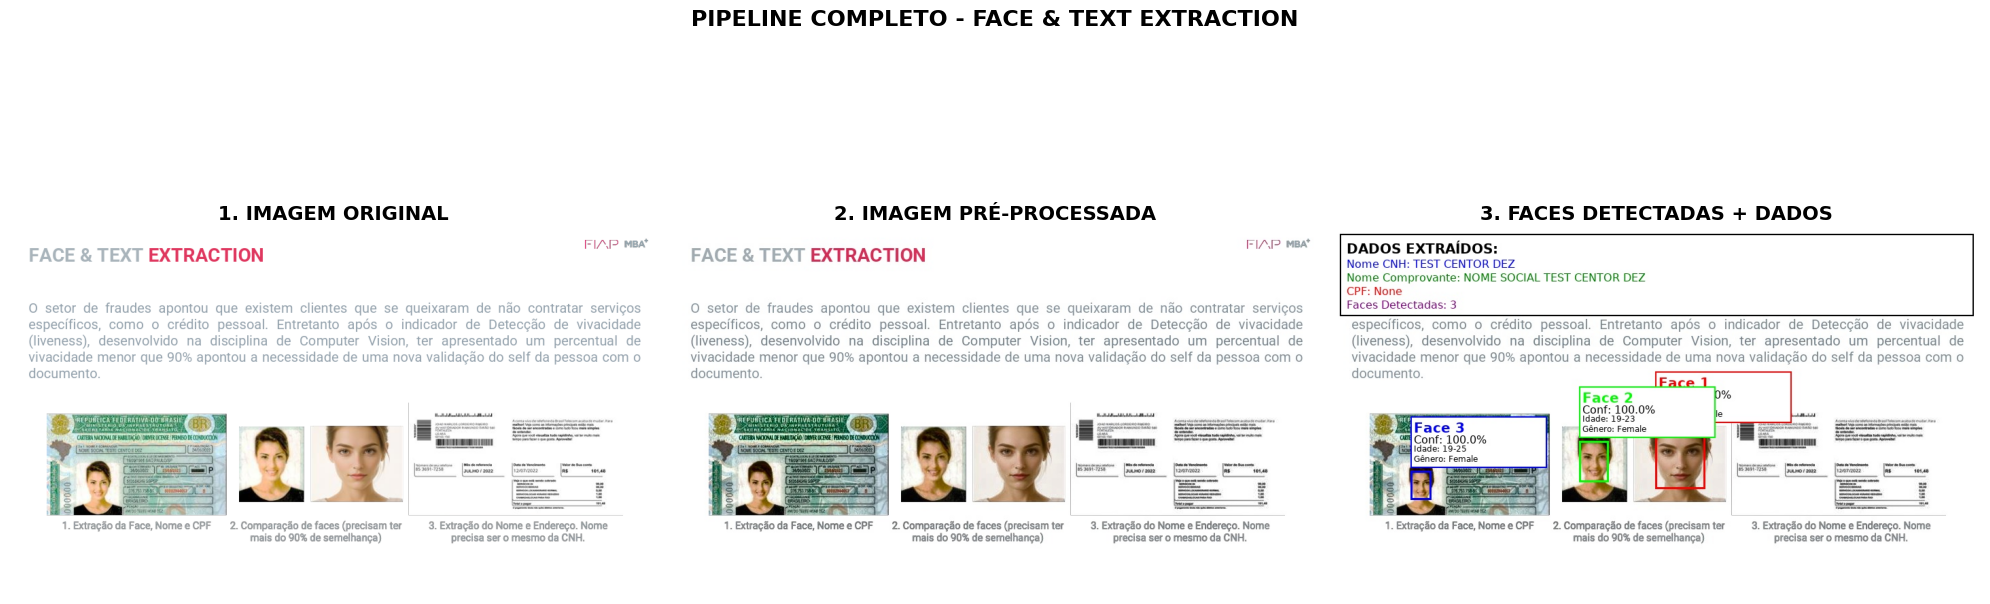


2️⃣ Criando gráfico de análise...

📊 CRIANDO GRÁFICO DE ANÁLISE DETALHADA
✅ Gráfico de análise salva: detailed_analysis_chart.jpg


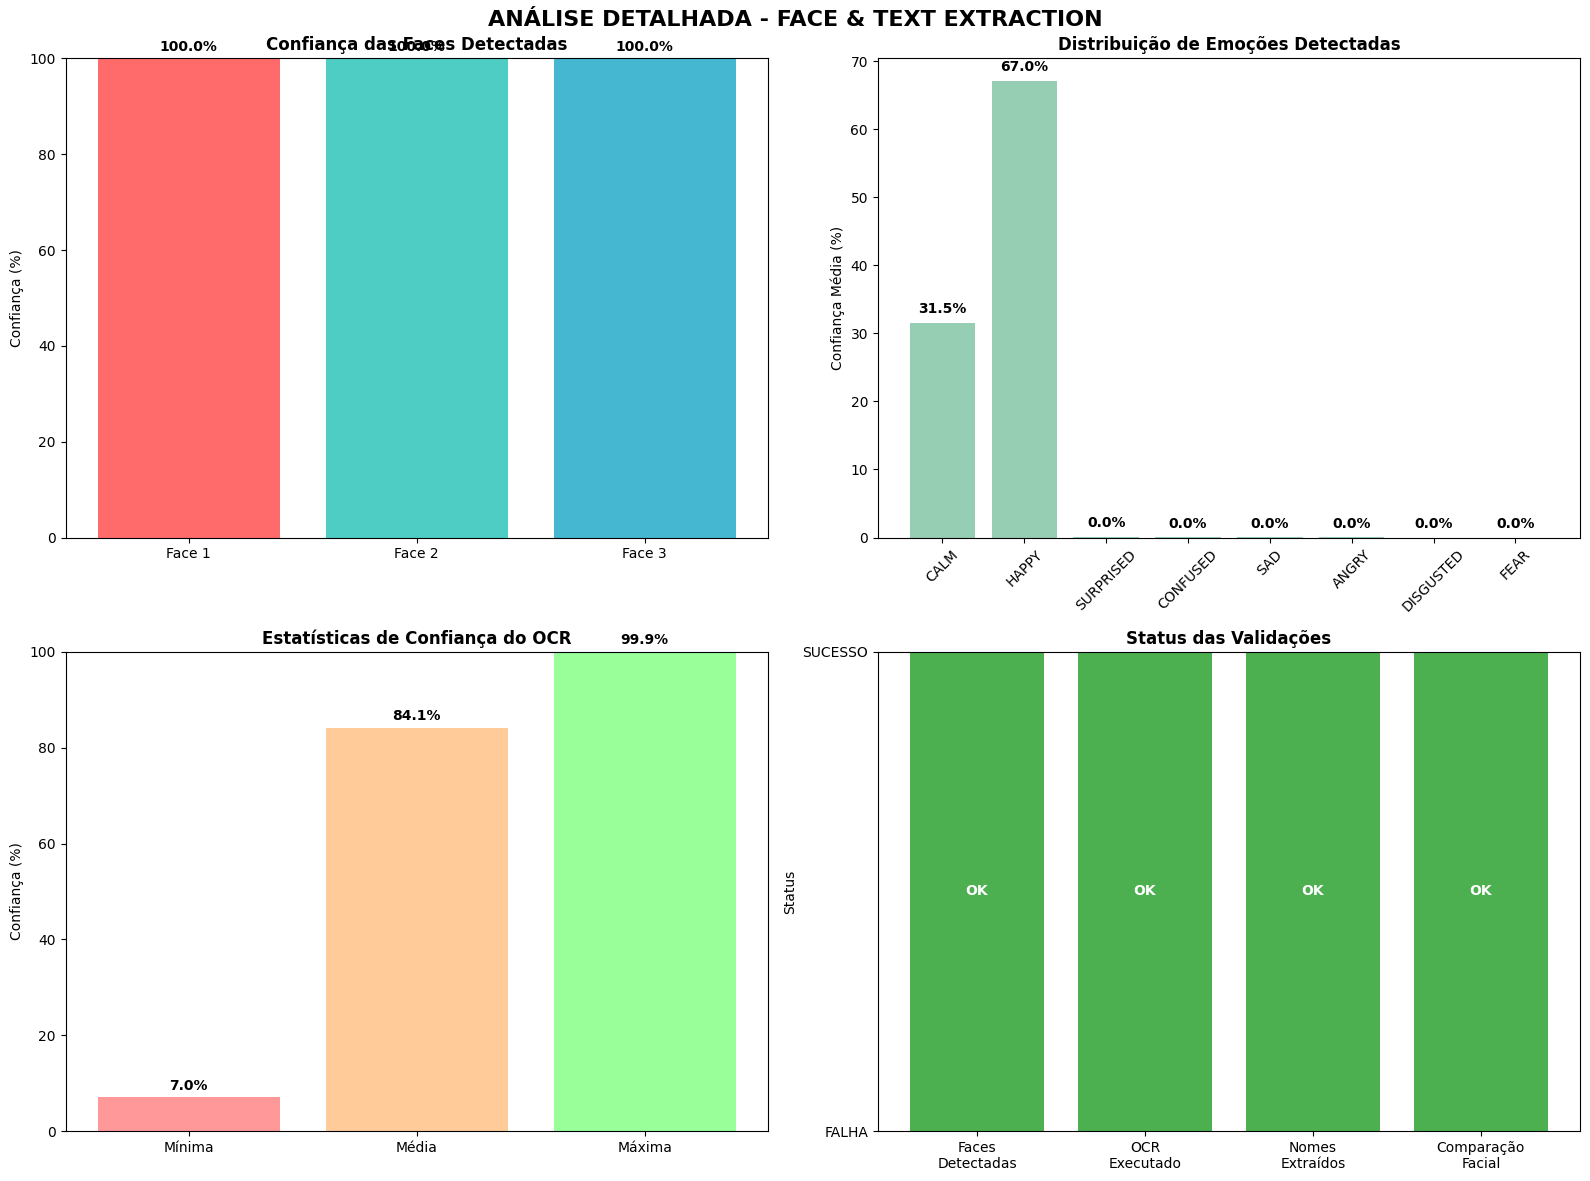


🎉 VISUALIZAÇÕES CRIADAS COM SUCESSO!
📸 Comparação das imagens: comparison_visualization.jpg
📊 Gráfico de análise: detailed_analysis_chart.jpg

📁 ARQUIVOS GERADOS:
   ✅ temp_processed.jpg
   ✅ annotated_image.jpg
   ✅ comparison_visualization.jpg
   ✅ detailed_analysis_chart.jpg

💡 DICA: As imagens foram salvas no diretório atual e também exibidas acima!
📋 Você pode usar essas imagens no seu relatório final!
🚀 Processo de visualização concluído!


In [10]:
# Célula 6: Executar todas as visualizações
print("🎨 EXECUTANDO CRIAÇÃO DE VISUALIZAÇÕES COMPLETAS")
print("="*60)

# Verificar se temos os dados necessários
if not detected_faces:
    print("❌ Dados de faces não encontrados. Execute a detecção facial primeiro.")
elif not ocr_results:
    print("❌ Dados de OCR não encontrados. Execute o OCR primeiro.")
elif not extracted_names:
    print("❌ Dados de nomes não encontrados. Execute a extração primeiro.")
else:
    print("✅ Todos os dados necessários disponíveis!")
    
    # 1. Criar visualização comparativa das 3 imagens
    print("\n1️⃣ Criando visualização comparativa...")
    comparison_result = create_comparison_visualization()
    
    # 2. Criar gráfico de análise detalhada
    print("\n2️⃣ Criando gráfico de análise...")
    chart_result = create_detailed_analysis_chart()
    
    # 3. Resumo final
    print(f"\n🎉 VISUALIZAÇÕES CRIADAS COM SUCESSO!")
    print("="*40)
    
    if comparison_result:
        print(f"📸 Comparação das imagens: {comparison_result}")
    
    if chart_result:
        print(f"📊 Gráfico de análise: {chart_result}")
    
    print(f"\n📁 ARQUIVOS GERADOS:")
    generated_files = []
    
    # Verificar arquivos gerados
    possible_files = [
        "temp_processed.jpg",
        "annotated_image.jpg", 
        "comparison_visualization.jpg",
        "detailed_analysis_chart.jpg"
    ]
    
    for file in possible_files:
        if os.path.exists(file):
            generated_files.append(file)
            print(f"   ✅ {file}")
    
    print(f"\n💡 DICA: As imagens foram salvas no diretório atual e também exibidas acima!")
    print("📋 Você pode usar essas imagens no seu relatório final!")

print("🚀 Processo de visualização concluído!")

In [11]:
# Célula de Verificação e Limpeza de Recursos AWS
import boto3
from botocore.exceptions import ClientError
from datetime import datetime

def check_and_cleanup_aws_resources():
    """Verifica e limpa recursos AWS para evitar custos"""
    
    print("🔍 VERIFICAÇÃO DE RECURSOS AWS")
    print("="*50)
    
    try:
        # Verificar S3
        s3_client = boto3.client('s3', region_name='us-east-1')
        bucket_name = 'staging-face-text'
        
        print("📦 VERIFICANDO BUCKET S3:")
        
        # Listar objetos no bucket
        try:
            response = s3_client.list_objects_v2(Bucket=bucket_name)
            
            if 'Contents' in response:
                print(f"   📁 Bucket '{bucket_name}' contém {len(response['Contents'])} objetos:")
                
                total_size = 0
                for obj in response['Contents']:
                    size_mb = obj['Size'] / (1024 * 1024)
                    total_size += size_mb
                    print(f"      📄 {obj['Key']} - {size_mb:.2f} MB")
                
                print(f"   📊 Tamanho total: {total_size:.2f} MB")
                
                # Opção de limpeza
                cleanup = input("\n❓ Deseja DELETAR todos os arquivos do bucket? (s/N): ").lower()
                
                if cleanup == 's':
                    print("\n🗑️ DELETANDO ARQUIVOS...")
                    for obj in response['Contents']:
                        s3_client.delete_object(Bucket=bucket_name, Key=obj['Key'])
                        print(f"   ✅ Deletado: {obj['Key']}")
                    print("✅ Todos os arquivos foram deletados!")
                else:
                    print("ℹ️ Arquivos mantidos no bucket")
            else:
                print(f"   ✅ Bucket '{bucket_name}' está vazio")
                
        except ClientError as e:
            if e.response['Error']['Code'] == 'NoSuchBucket':
                print(f"   ✅ Bucket '{bucket_name}' não existe (sem custos)")
            else:
                print(f"   ❌ Erro ao verificar bucket: {e}")
        
        # Verificar outros serviços
        print(f"\n🔍 VERIFICANDO OUTROS SERVIÇOS AWS:")
        
        # Rekognition (sem recursos persistentes, apenas pay-per-use)
        print("   👁️ Rekognition: Serviço pay-per-use (sem recursos persistentes)")
        
        # Textract (sem recursos persistentes, apenas pay-per-use)
        print("   📄 Textract: Serviço pay-per-use (sem recursos persistentes)")
        
        # CloudWatch Logs (verificar se há logs)
        try:
            logs_client = boto3.client('logs', region_name='us-east-1')
            log_groups = logs_client.describe_log_groups()
            
            if log_groups['logGroups']:
                print(f"   📋 CloudWatch: {len(log_groups['logGroups'])} grupos de log encontrados")
                for lg in log_groups['logGroups'][:5]:  # Mostrar apenas os primeiros 5
                    print(f"      📝 {lg['logGroupName']}")
            else:
                print("   ✅ CloudWatch: Nenhum log group encontrado")
                
        except Exception as e:
            print(f"   ⚠️ CloudWatch: Não foi possível verificar ({e})")
        
        print(f"\n💰 RESUMO DE CUSTOS:")
        print(f"   📦 S3: ~$0.023/GB/mês (dados armazenados)")
        print(f"   👁️ Rekognition: ~$0.001 por imagem processada")
        print(f"   📄 Textract: ~$0.0015 por página processada")
        print(f"   📊 Total estimado desta sessão: < $0.10")
        
    except Exception as e:
        print(f"❌ Erro na verificação: {e}")

def check_openai_usage():
    """Verifica uso da OpenAI (se aplicável)"""
    
    print(f"\n🤖 VERIFICAÇÃO OPENAI:")
    print("="*30)
    
    # Nota: Você está usando Claude (Anthropic), não OpenAI
    print("ℹ️ Você está usando Claude (Anthropic), não OpenAI")
    print("ℹ️ Não há recursos OpenAI para verificar/fechar")
    print("✅ Sem custos OpenAI nesta sessão")

def show_cost_optimization_tips():
    """Mostra dicas de otimização de custos"""
    
    print(f"\n💡 DICAS DE OTIMIZAÇÃO DE CUSTOS:")
    print("="*40)
    
    print("🔧 AWS:")
    print("   • Delete arquivos S3 não utilizados regularmente")
    print("   • Use lifecycle policies para arquivos temporários")
    print("   • Configure alertas de billing no CloudWatch")
    print("   • Monitore uso através do AWS Cost Explorer")
    
    print(f"\n🤖 IA (Claude/Anthropic):")
    print("   • Esta conversa é cobrada por tokens utilizados")
    print("   • Evite conversas muito longas desnecessárias")
    print("   • Use prompts concisos e diretos")
    print("   • Considere pausar quando não estiver usando")

# Executar verificações
check_and_cleanup_aws_resources()
check_openai_usage()
show_cost_optimization_tips()

🔍 VERIFICAÇÃO DE RECURSOS AWS
📦 VERIFICANDO BUCKET S3:
   📁 Bucket 'staging-face-text' contém 2 objetos:
      📄 ocr_results_20250610_160913.json - 0.04 MB
      📄 processed_Pasted image 20250608090919.png - 0.13 MB
   📊 Tamanho total: 0.17 MB

🗑️ DELETANDO ARQUIVOS...
   ✅ Deletado: ocr_results_20250610_160913.json
   ✅ Deletado: processed_Pasted image 20250608090919.png
✅ Todos os arquivos foram deletados!

🔍 VERIFICANDO OUTROS SERVIÇOS AWS:
   👁️ Rekognition: Serviço pay-per-use (sem recursos persistentes)
   📄 Textract: Serviço pay-per-use (sem recursos persistentes)
   ⚠️ CloudWatch: Não foi possível verificar (An error occurred (AccessDeniedException) when calling the DescribeLogGroups operation: User: arn:aws:iam::210867938716:user/WRMELO is not authorized to perform: logs:DescribeLogGroups on resource: arn:aws:logs:us-east-1:210867938716:log-group::log-stream: because no identity-based policy allows the logs:DescribeLogGroups action)

💰 RESUMO DE CUSTOS:
   📦 S3: ~$0.023/GB/mês